## Cifar 10 Convolutional Neural Network Implementation

This work contains the implementation of two kind of Neural Networks (AlexNet and a Custom model based in LeeNet and AlexNet), validating their capacity to classify the CIFAR10 dataset, a set of images that contains 10 different classes.

In [4]:
# Pytorch Imports #
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler

# Torchvision Imports #
import torchvision.datasets as datasets
import torchvision.transforms as T

# matplotlib imports #
import matplotlib.pyplot as plt

# numpy imports #
import numpy as np

### Import Libraries needed for Google Drive mount

In [ ]:
# Library installaation using pip for linux backend of colab#
!pip install -U -q PyDrive

# Import of Libraries from Drive using google collab api #
import os

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

from google.colab import drive
from google.colab import auth

from oauth2client.client import GoogleCredentials

### <u>Function used to Download data from Drive</u> :

In [ ]:
# Function for downloading especific Data from the Drive folders #
def download_Data(file_list, string_Discriminator):
  # Check inside the folder if is already downlaoded #
  downloaded = []

  for path in os.scandir("/content/"):
    downloaded.append(path.name)

  # Iterate through the files and download them to the data folder if not already downloaded, and are of the givne extension type#
  for files in file_list:
    if (string_Discriminator in files['title']) & (files['title'] not in downloaded):
      print('title: %s, id: %s' % (files['title'], files['id']))
      fname = os.path.join(local_download_path, files['title'])
      print('downloading to {}'.format(fname))
      f_ = drive.CreateFile({'id': files['id']})
      f_.GetContentFile(fname)
      downloaded.append(fname)

### Import Files from Drive

In [ ]:
from google.colab import drive

#Authentication and creation the PyDrive client.
auth.authenticate_user()   #See if credentials are valid
gauth = GoogleAuth()       #Start the authentication of the collab
gauth.credentials = GoogleCredentials.get_application_default()
drive.mount("/content/gdrive")  #Mounts drive in the collab to save the important data
drive = GoogleDrive(gauth) #Finishes the authentication

#Choose a local directory inside the colab to import the data.
local_download_path = os.path.expanduser('/content')

# Try to make the directories in the colab #
try:
  os.makedirs(local_download_path)
except: pass

#Iterate through items using the query syntax for google drive
#https://developers.google.com/drive/v2/web/search-parameters

# Create a file list based on the query syntax searching in our drive folder and download it#
file_list = drive.ListFile(
    {'q': "'1YtW460uumEGz954lHPNUsbwFnjs_tfgW' in parents"}).GetList()

# Download only files from these types from Drive folder 1sqEm5Pvxcg2X2yF2jkZKoojJmSXpysXe #
download_Data(file_list,".py")
download_Data(file_list,".pt")

### Import User Functions

In [6]:
# User files Imports #
from models.customNet import CNN_custom
from models.alexNet import CNN_AlexNet

from utils.dataset_utils import cifar10_dataset_Generator, verify_data
from utils.general_utils import get_available_devices, set_all_seeds
from utils.matplotlib_utils import plot_figure, plot_figures_grid, plot_minibatch_loss, plot_accuracy_epochs, plot_confusion_matrix, plot_model_outputs
from utils.models_utils import train_cnn, load_model, save_model, compute_total_accuracy, compute_confusion_matrix, get_integrated_gradient, get_occlusion, get_convolutional_layer_weights, get_outputs

## Cuda Verification

In [7]:
device = get_available_devices()

NVIDIA GeForce GTX 1660 Ti


### Set initial Seed for Neural Network
Allows us to shuffle the model in the same way if we want to get the same initial weights with a Re-Run

In [8]:
set_all_seeds(0)

### Configure Dataset

We need to prepare the data for the different models training, so the data is transformed using the next parameters:

- Image Dimensions: Original - 32 x 32 x 3, Augmented and cropped - 64 x 64 x 3
- Training Dataset samples - 50000
- Validation Dataset samples - 10000
- Test Dataset samples - 10000
- Minibatch size - 64
- Erasing of pixels - Probability: 0.05, Scale of Erased portion: 0.05, 0.1, Colors Erased: random

Using this augmentation technics we can augmentate the number of images in the dataset, making them different than the original set. This way the networks can train without overfitting the model. In this case the data is not normalized, but the distribution of the clases inside of the dataloaders are evenly distributed. 

In [9]:
# Dataset Configuration #
MINIBATCH_SIZE = 64
DOWNLOAD = True
LOG = True

# Dataset Transformation Tensor using CIFAR 10 Normalized standar #
transform_cifar = T.Compose([T.ToTensor(),
                             T.Resize((70, 70)),
                             T.RandomCrop((64, 64)),
                             T.RandomErasing(0.05,(0.05,0.1),value="random"),
                             ])

train_data_loader, validation_data_loader, test_data_loader = cifar10_dataset_Generator(transform_cifar,MINIBATCH_SIZE,DOWNLOAD,LOG)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./Cifar10_Data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(70, 70), interpolation=bilinear, max_size=None, antialias=warn)
               RandomCrop(size=(64, 64), padding=None)
               RandomErasing(p=0.05, scale=(0.05, 0.1), ratio=(0.3, 3.3), value=random, inplace=False)
           )


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./Cifar10_Data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(70, 70), interpolation=bilinear, max_size=None, antialias=warn)
               RandomCrop(size=(64, 64), padding=None)
               RandomErasing(p=0.05, scale=(0.05, 0.1), ratio=(0.3, 3.3), value=random, inplace=False)
           )


Dataset CIFAR10
    Num

### Verification of Dataloaders

In [10]:
verify_data(train_data_loader.dataset, validation_data_loader.dataset, test_data_loader.dataset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./Cifar10_Data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(70, 70), interpolation=bilinear, max_size=None, antialias=warn)
               RandomCrop(size=(64, 64), padding=None)
               RandomErasing(p=0.05, scale=(0.05, 0.1), ratio=(0.3, 3.3), value=random, inplace=False)
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./Cifar10_Data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(70, 70), interpolation=bilinear, max_size=None, antialias=warn)
               RandomCrop(size=(64, 64), padding=None)
               RandomErasing(p=0.05, scale=(0.05, 0.1), ratio=(0.3, 3.3), value=random, inplace=False)
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./Cifar10_Data
    Split: Test
    StandardTransform
Transform: Compose(
 

### Show Single Image

The image Class is: cat


C:\Users\oswy2\Documents\Redes_Neuronales\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


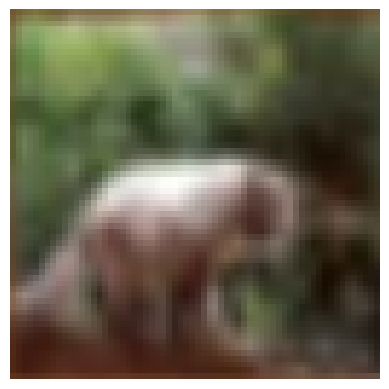

In [11]:
plot_figure(train_data_loader)

### Show Multiple Images

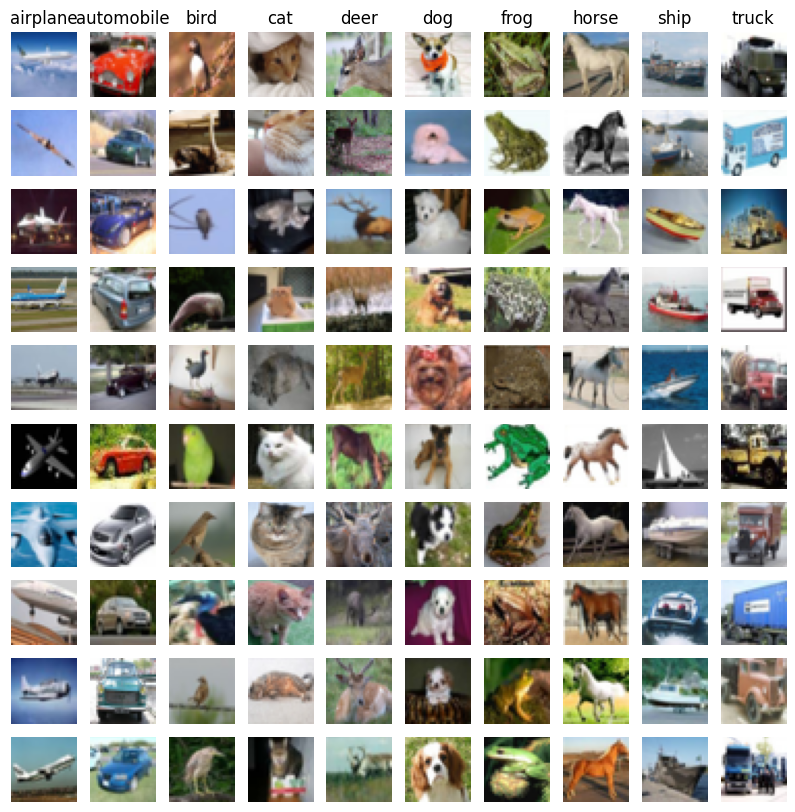

In [12]:
plot_figures_grid(train_data_loader)

### Define Layer Hook Function

In [17]:
# Get activation layers #
layer_outputs = {}
def get_activation_layer(
    name: str,
) -> None:
    """
    Parameters
    ----------
    name : str

    Returns
    ----------
    None.

    Notes
    ----------
    Function for obtaining activation layer for a given name.
    """

    # declare hook function for saving outputs #
    def hook(model, input, output):
        layer_outputs[name] = output.detach()
        
    return hook

### AlexNet Paper Model

References

[1] Krizhevsky, Alex, Ilya Sutskever, and Geoffrey E. Hinton. "Imagenet classification with deep convolutional neural networks." In Advances in Neural Information Processing Systems, pp. 1097-1105. 2012.

- This model has an architecture with maxpooling and dropout, with the next hyperparameters.
- Learning Rate: 0.0001
- Epochs: 20
- Minibatch: 64
- Optimizer: Adams

### Neural Network AlexNet Model Implementation

In [18]:
# Hyperparameters Definitions
LEARNING_RATE = 0.0001
NUM_EPOCHS = 20

# Architecture
NUM_CLASSES = 10

# Model extension save
Model_NAME = "alexNet.pt"

# Create model using AlexNet class
alexNet_model = CNN_AlexNet(NUM_CLASSES)

# Load Model #
load_model(alexNet_model,Model_NAME)
alexNet_model.to(device)

# Optimizer implementation - Adam
optimizer = torch.optim.Adam(alexNet_model.parameters(), lr=LEARNING_RATE)

### Hook layers to dictionary

In [21]:
alexNet_model_children = list(alexNet_model.children())

# Set convolutional layers Hooks  #
alexNet_model_children[0][0].register_forward_hook(get_activation_layer('convolutional_0'))
alexNet_model_children[0][3].register_forward_hook(get_activation_layer('convolutional_1'))
alexNet_model_children[0][6].register_forward_hook(get_activation_layer('convolutional_2'))
alexNet_model_children[0][8].register_forward_hook(get_activation_layer('convolutional_3'))
alexNet_model_children[0][10].register_forward_hook(get_activation_layer('convolutional_4'))

# Set MaxPool hooks #
alexNet_model_children[0][2].register_forward_hook(get_activation_layer('max_pool_0'))
alexNet_model_children[0][5].register_forward_hook(get_activation_layer('max_pool_1'))
alexNet_model_children[0][12].register_forward_hook(get_activation_layer('max_pool_2'))

### Compute Accuracy

In [23]:
compute_total_accuracy(alexNet_model,train_data_loader,validation_data_loader,test_data_loader,device)

Train ACC: 87.15%
Validation ACC: 72.36%
Test ACC: 71.98%


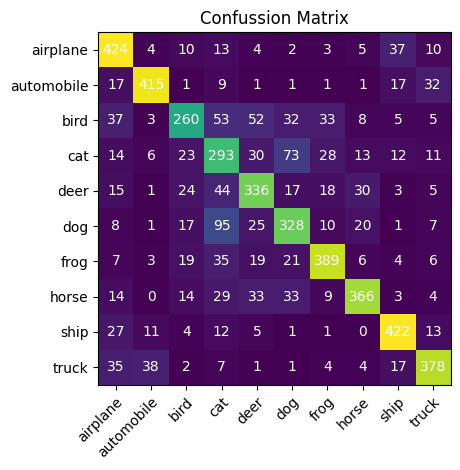

In [25]:
matrix, labels =  compute_confusion_matrix(alexNet_model,test_data_loader,device)
plot_confusion_matrix(matrix,labels,"Confussion Matrix")

### Accuracy Achieved

- The model have an excelent accuracy with the training dataset this was achieved by training enough epochs with a good learning rate for the network.
- The model have a great accuracy with the Validation dataset, but it seems that it started to overfit because the validation started to diminish.
- The model have a great accuracy in the test dataset, but the effect of the overfitting started to affect it.

### Review outputs of Convolutional Layers

C:\Users\oswy2\Documents\Redes_Neuronales\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


The image Class is: ship


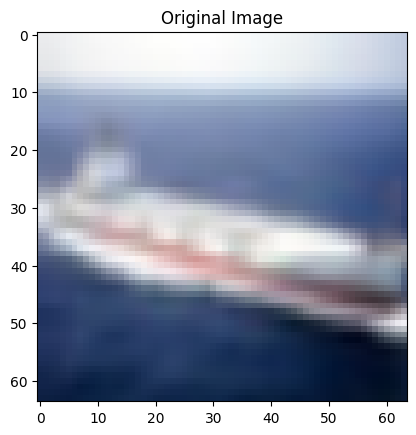

In [26]:
# Reset outputs#
layer_outputs = {}

# get output #
get_outputs(alexNet_model,test_data_loader)

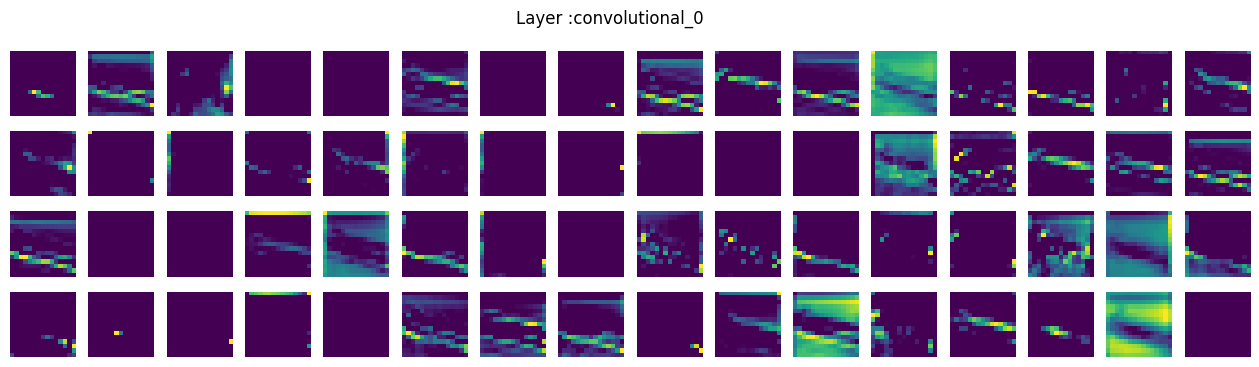

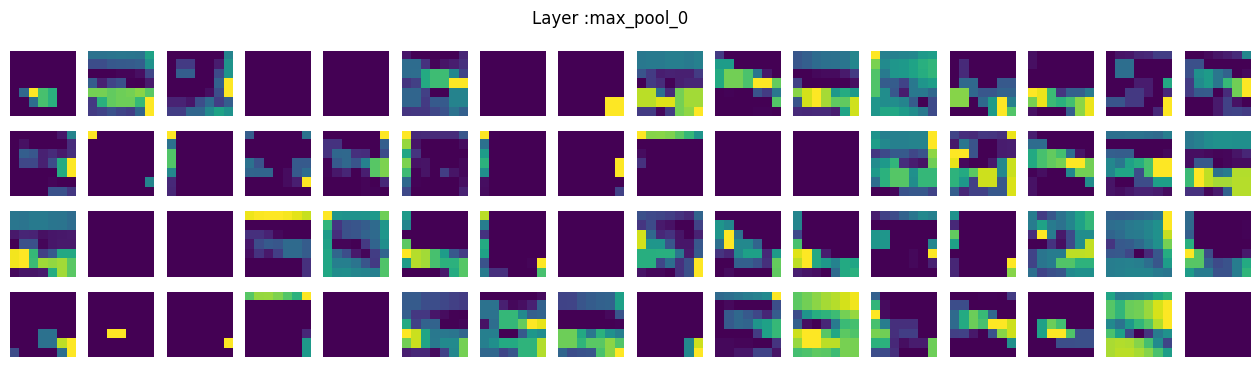

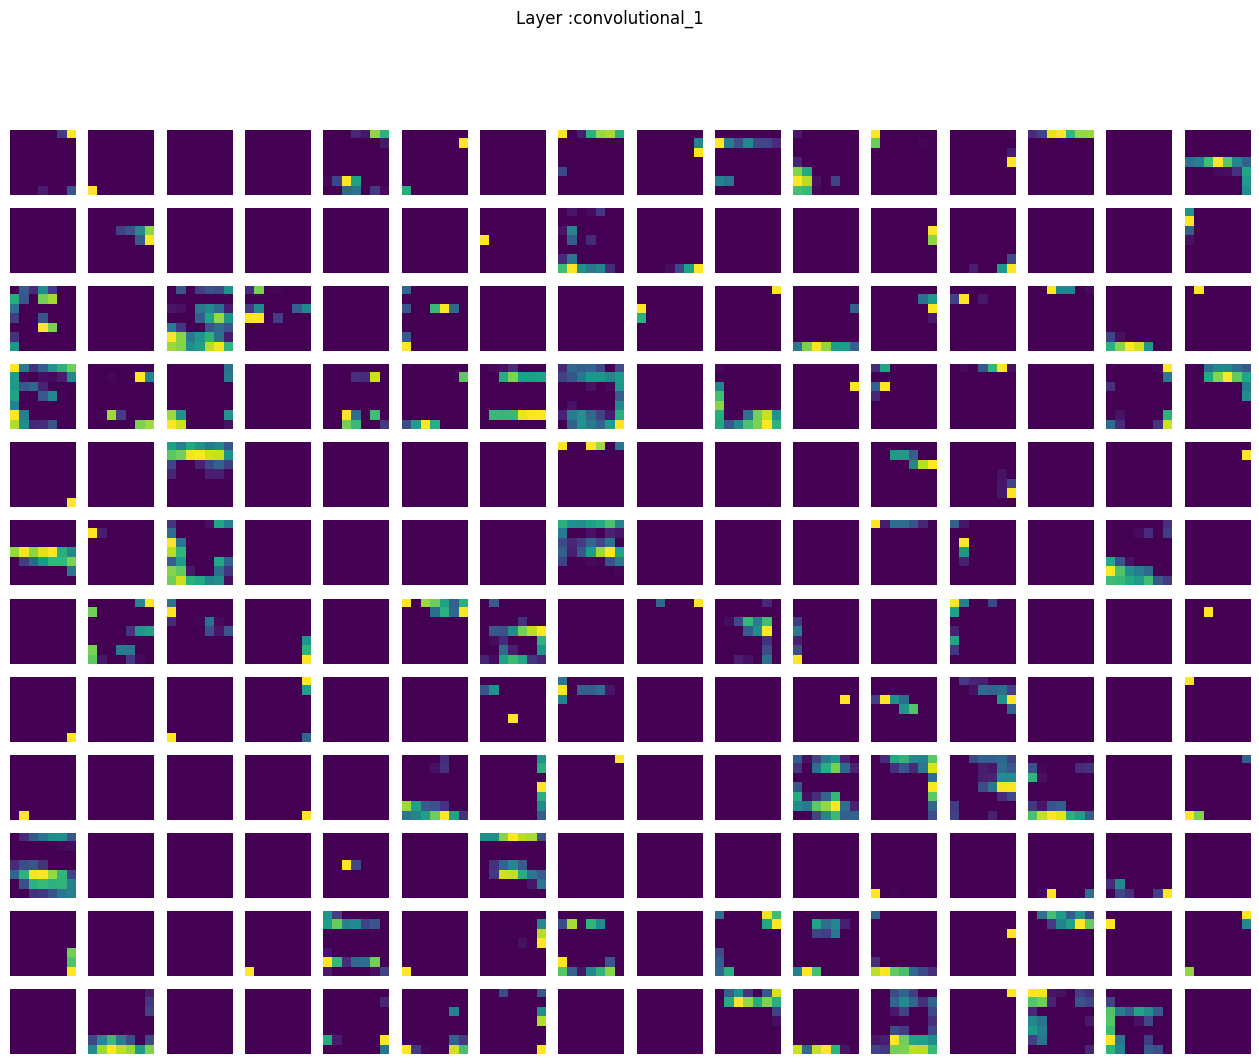

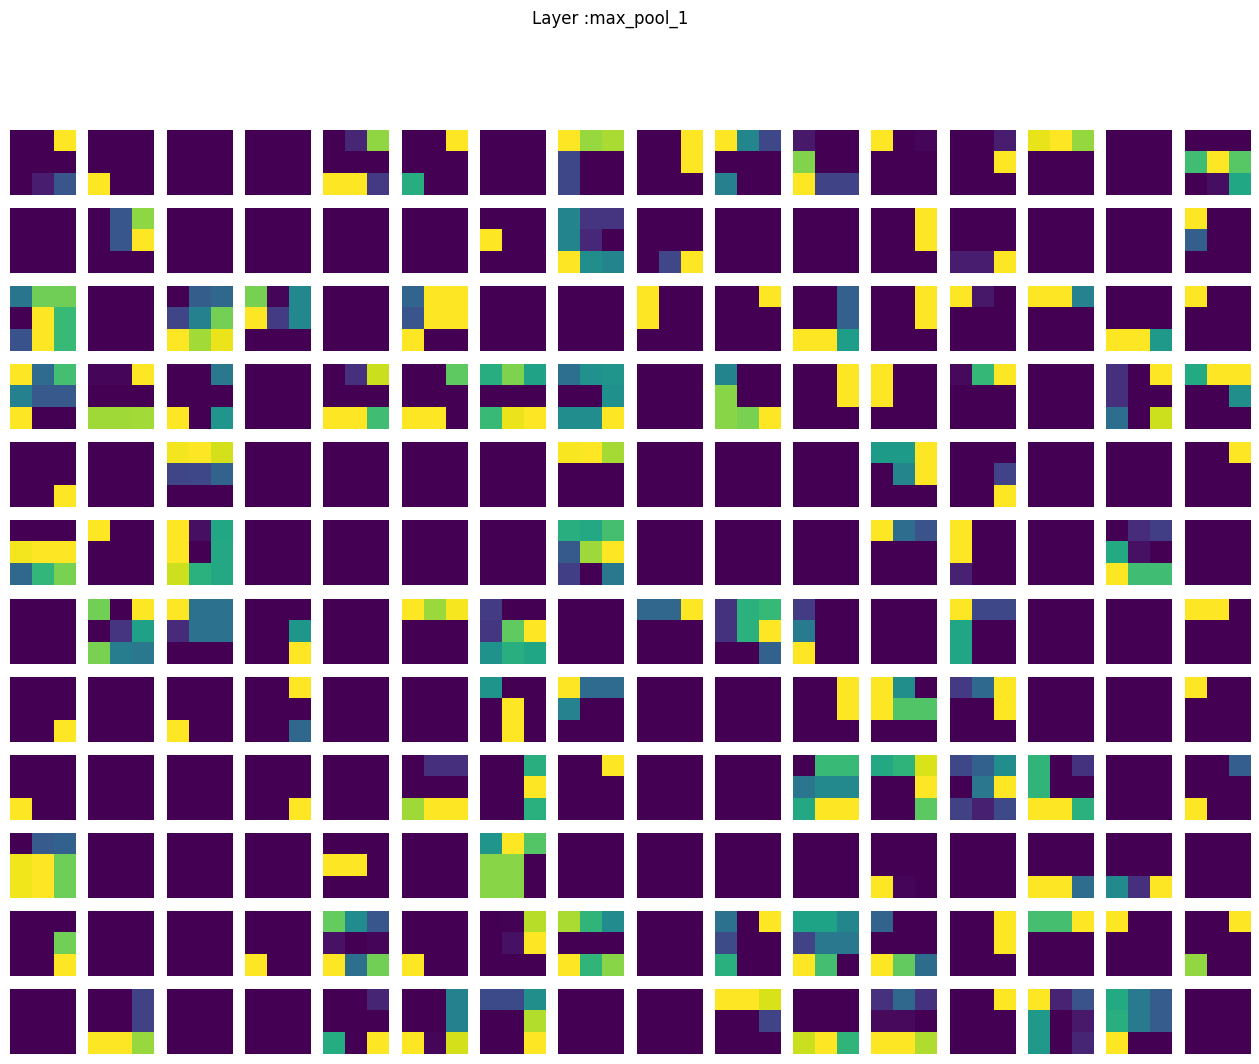

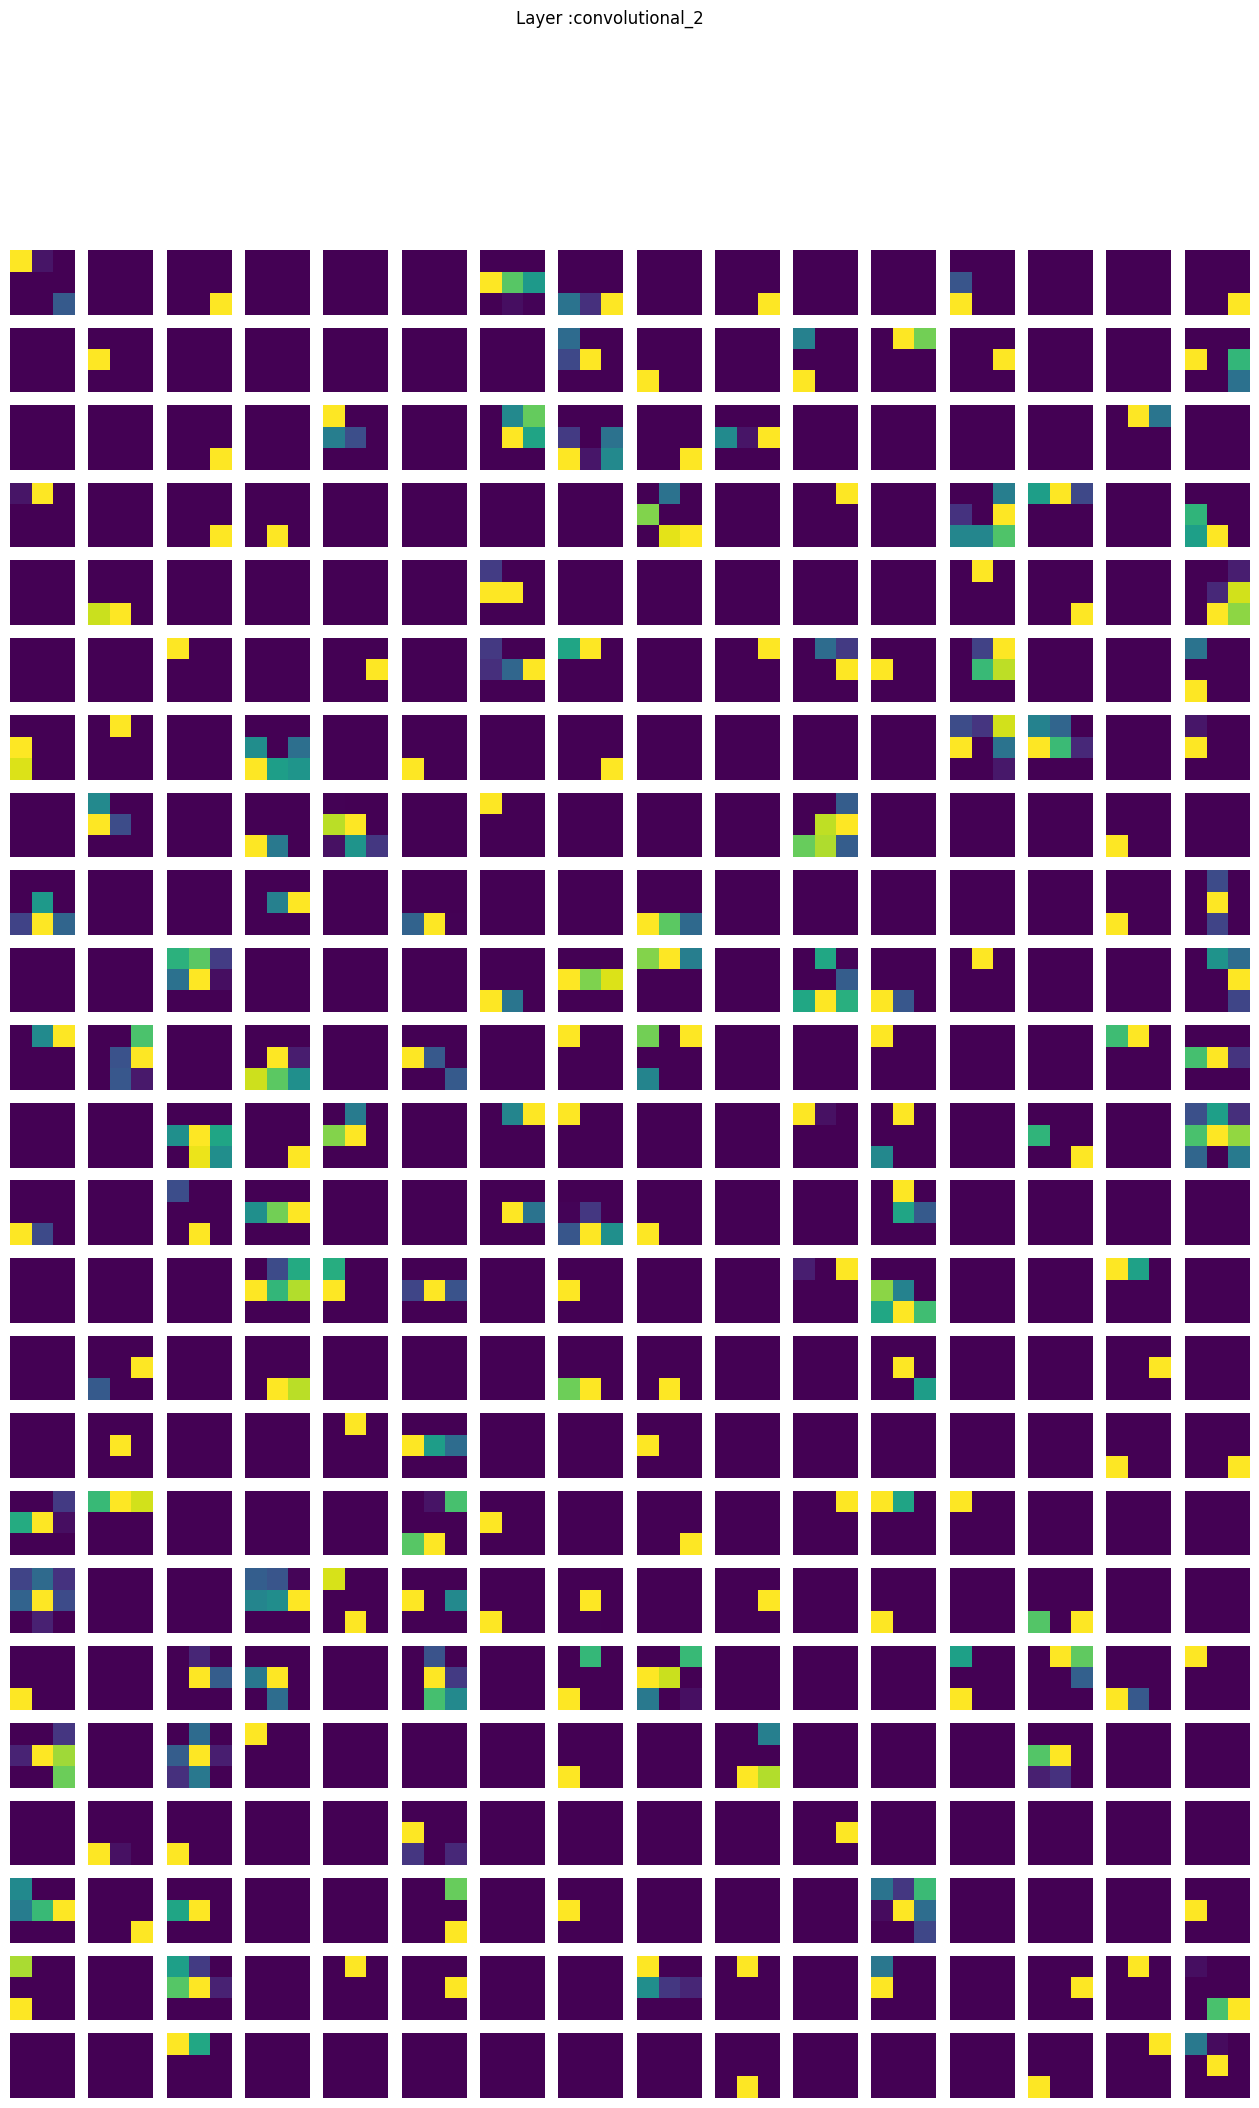

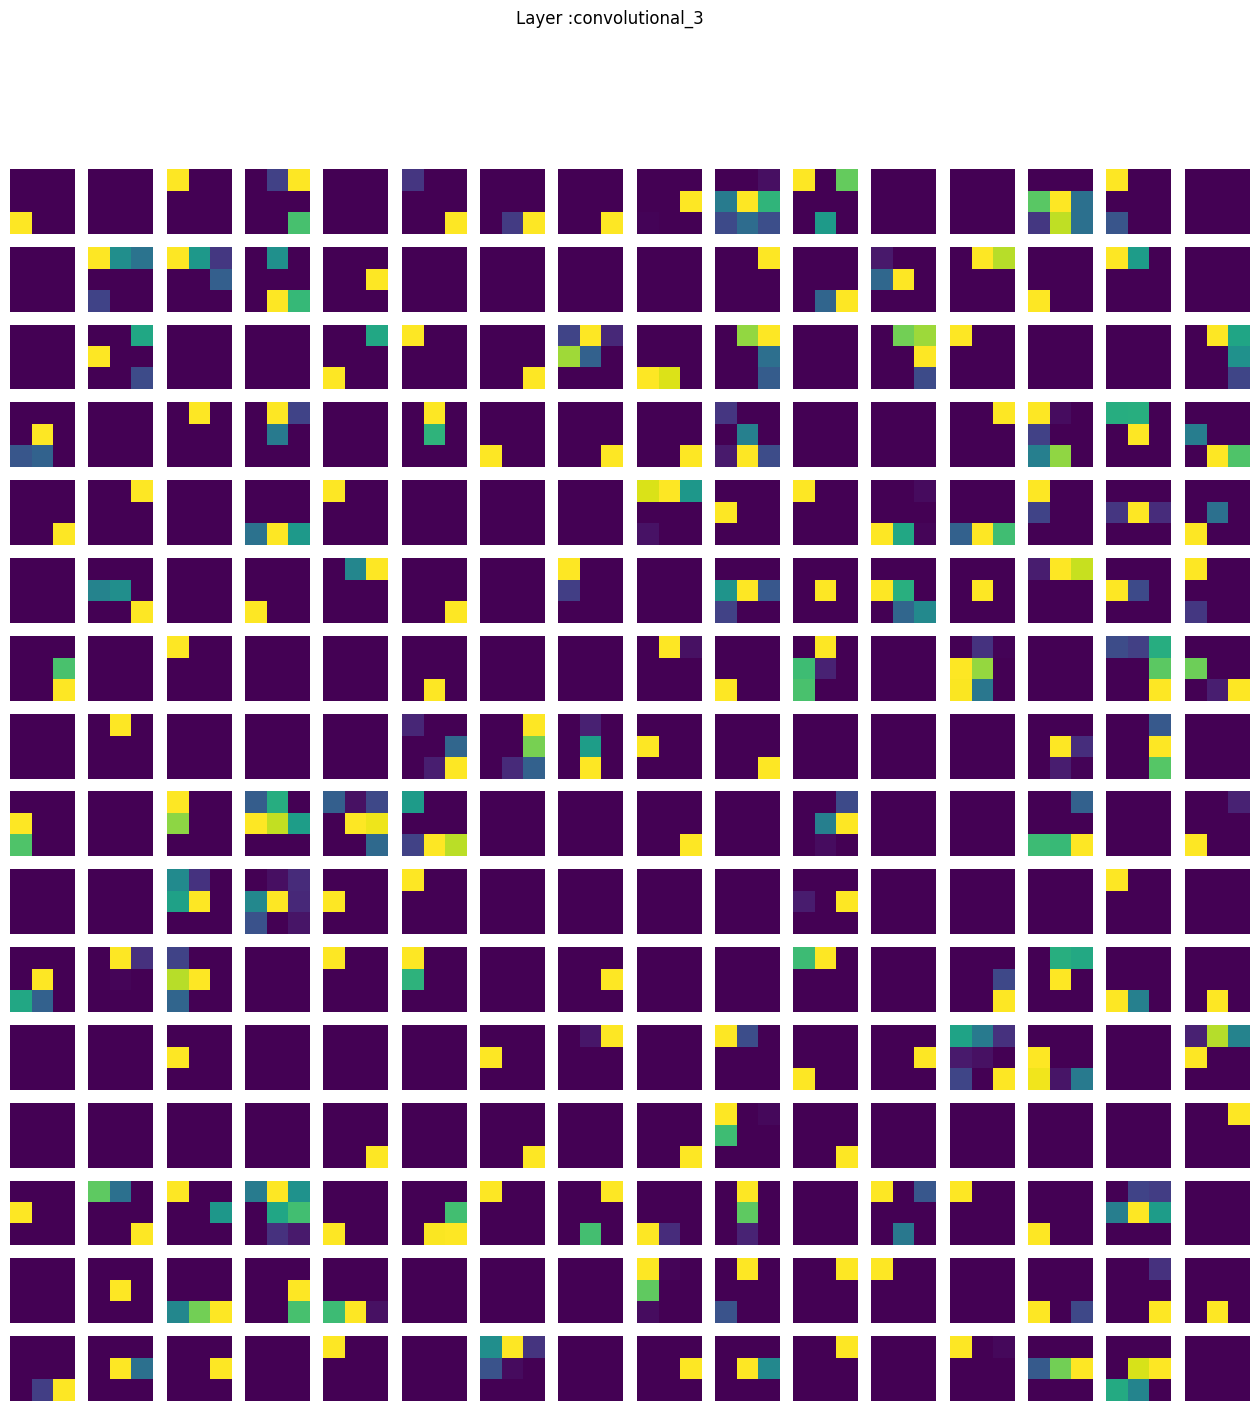

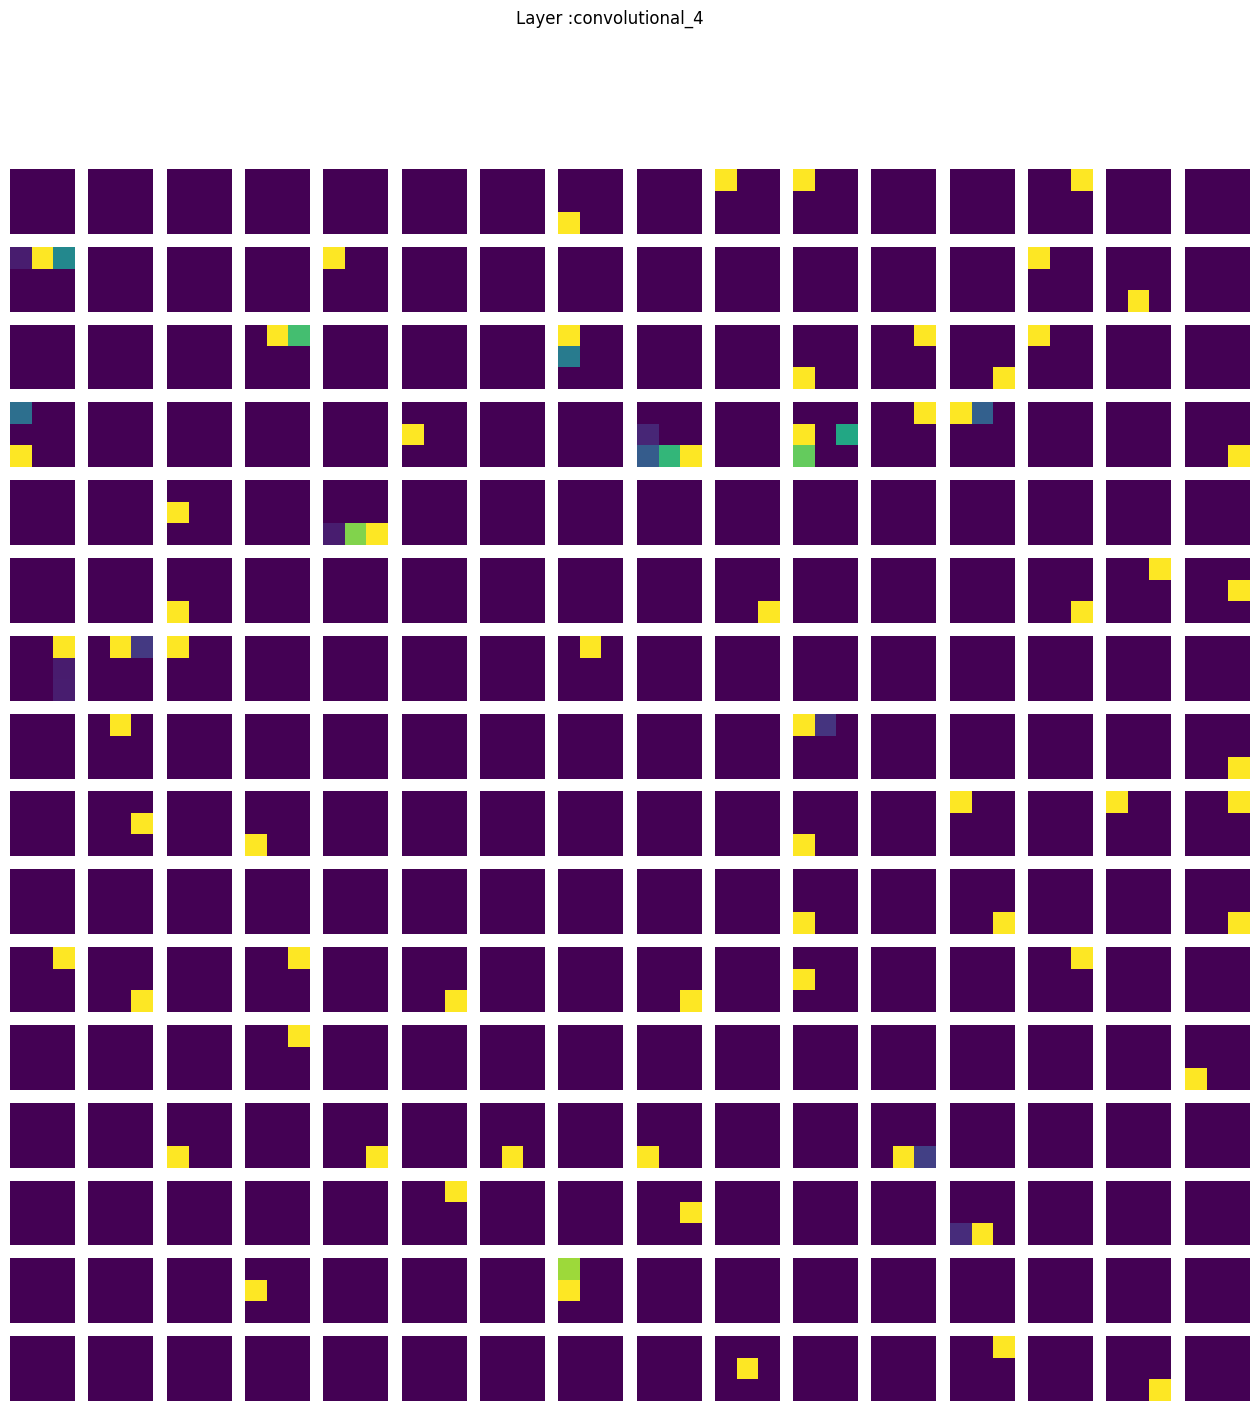

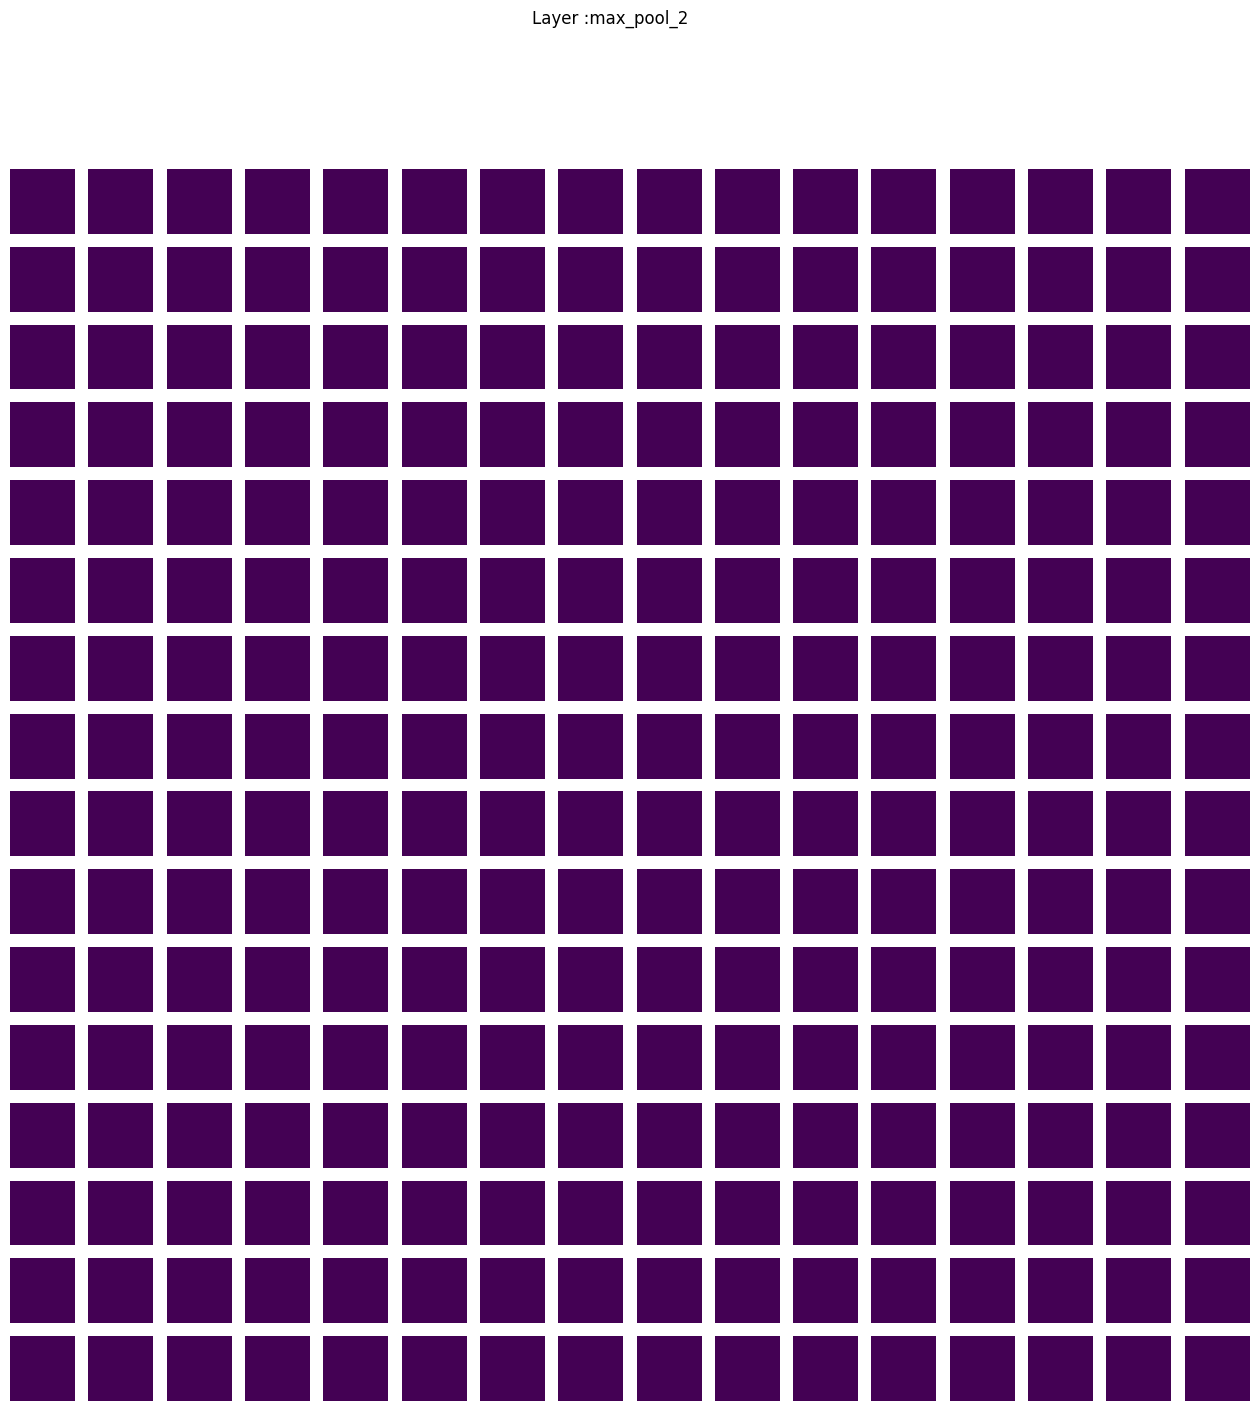

In [27]:
plot_model_outputs(layer_outputs)

### Hidden Layer explanaitions

- We can see the effect of the scale of the moddel on the max pooling 2 of the network, it also explains why the model can't train over certain accuracy.
- In the previous layers we can see the effect of the image, specially on the convolutional layer 0 and maxpooling layer 0, places where the kernels that are trained with certain patterns can detect patterns in the image.

### Neural Network Custom Model Implementation

- This model has an architecture with maxpooling and dropout, with the next hyperparameters.
- Learning Rate: 0.00038
- Epochs: 20
- Minibatch: 64
- Optimizer: Adams

In [38]:
# Hyperparameters Definitions
LEARNING_RATE = 0.00038
NUM_EPOCHS = 20

# Architecture
NUM_CLASSES = 10

# Model extension save
Model_NAME = "custom_net.pt"

# Create model using CNN_custom class
custom_model = CNN_custom(NUM_CLASSES)

# Load Model #
load_model(custom_model,Model_NAME)
custom_model.to(device)

# Optimizer implementation - Adam
optimizer = torch.optim.Adam(custom_model.parameters(), lr=LEARNING_RATE)

### Hook layers to dictionary

In [39]:
custom_model_children = list(custom_model.children())

# Set convolutional layers Hooks  #
custom_model_children[0][0].register_forward_hook(get_activation_layer('convolutional_0'))
custom_model_children[0][3].register_forward_hook(get_activation_layer('convolutional_1'))
custom_model_children[0][6].register_forward_hook(get_activation_layer('convolutional_2'))

# Set MaxPool hooks #
custom_model_children[0][2].register_forward_hook(get_activation_layer('max_pool_0'))
custom_model_children[0][5].register_forward_hook(get_activation_layer('max_pool_1'))
custom_model_children[0][8].register_forward_hook(get_activation_layer('max_pool_2'))

### Compute Accuracy

In [40]:
compute_total_accuracy(custom_model,train_data_loader,validation_data_loader,test_data_loader,device)

C:\Users\oswy2\Documents\Redes_Neuronales\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train ACC: 80.77%
Validation ACC: 73.38%
Test ACC: 73.52%


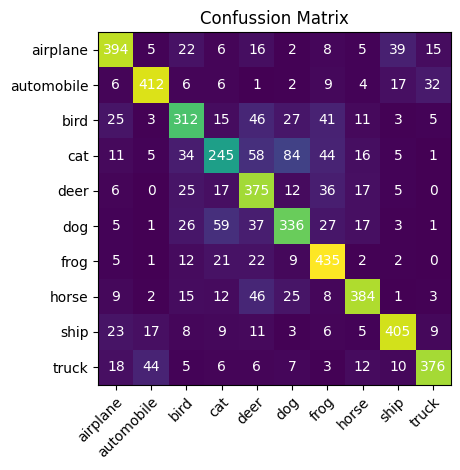

In [41]:
matrix, labels =  compute_confusion_matrix(custom_model,test_data_loader,device)
plot_confusion_matrix(matrix,labels,"Confussion Matrix")

### Accuracy Achieved

- The model have a great accuracy with the training dataset this was achieved by training enough epochs with a good learning rate for the network.
- The model have a great accuracy with the Validation dataset, so it was not overfitting through the training.
- The model have a great accuracy in the test dataset, so the network was trained accurately. We can see this on the cofussion matrix better.

### Review of Kernels

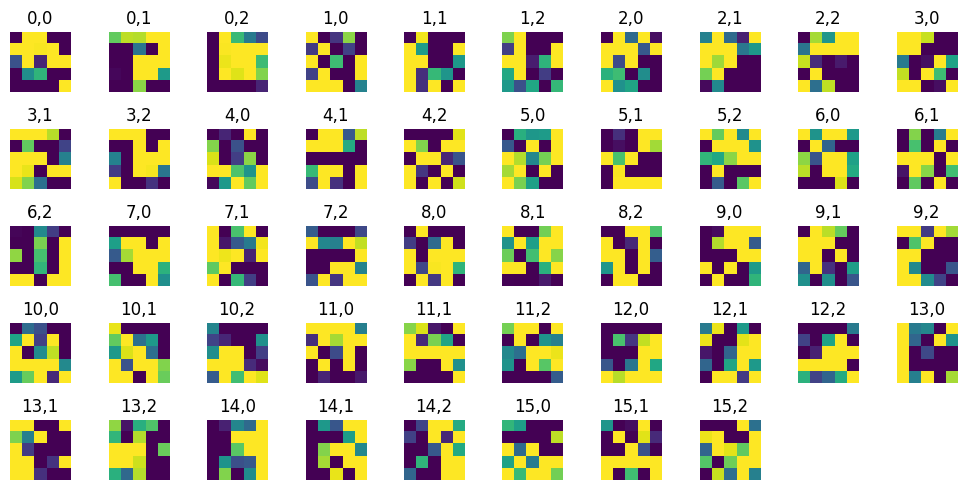

In [42]:
get_convolutional_layer_weights(custom_model,0,False)

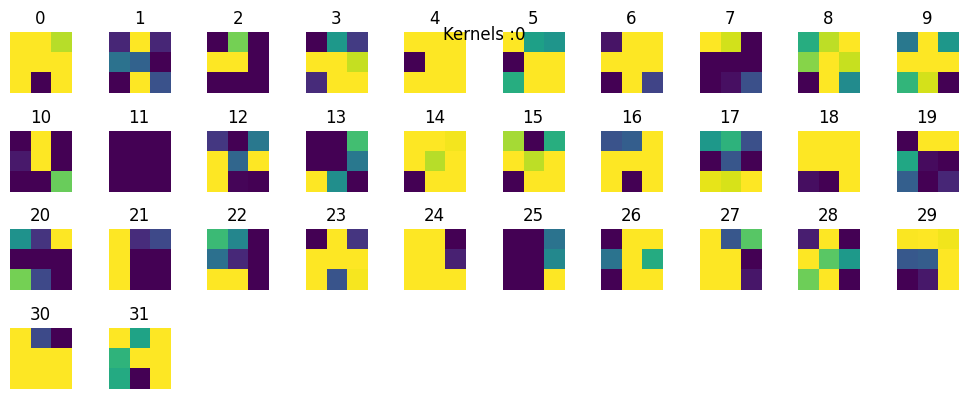

In [43]:
get_convolutional_layer_weights(custom_model,3,True)

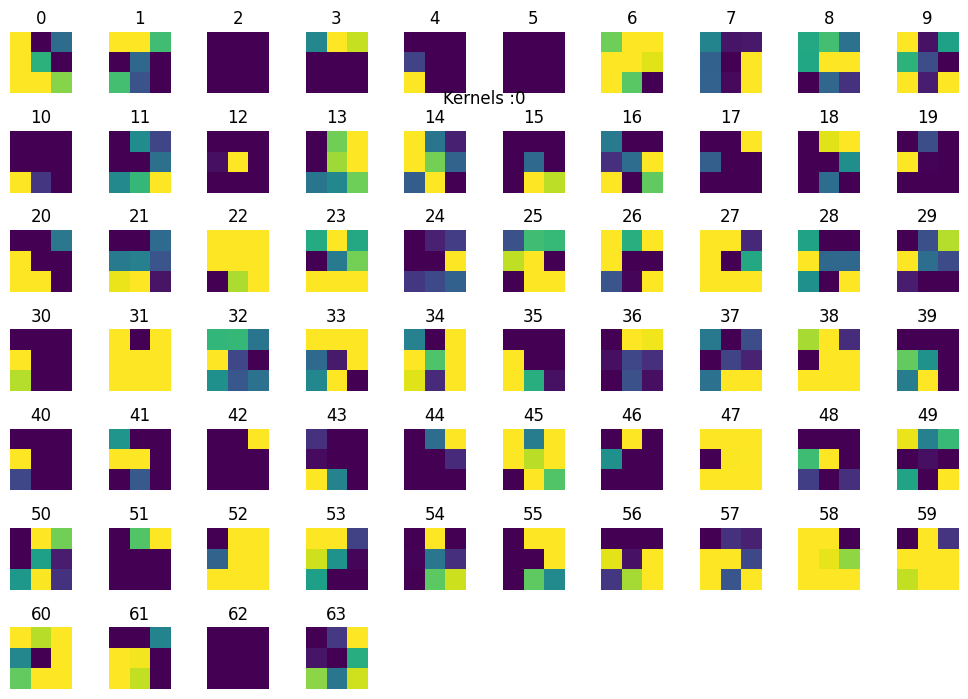

In [44]:
get_convolutional_layer_weights(custom_model,6,True)

### Review of Integrated gradients and Occlussion

- With the Integrated gradient we can get an estimate of the activation of the layers of the network, seeing that the features are being surrounded by patterns in a grey map.
- With Occlussion we can see the features that the network is marking and ignoring in the images, with the negative occlussion we can see the parts that are focused and the possitive oclussion shows the parts that are being left out.

C:\Users\oswy2\Documents\Redes_Neuronales\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Target label: bird


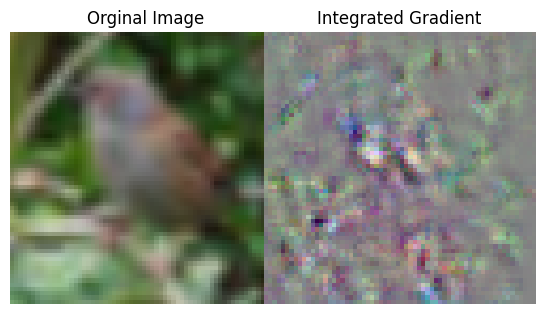

In [45]:
get_integrated_gradient(custom_model,test_data_loader)

C:\Users\oswy2\Documents\Redes_Neuronales\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Target label: cat


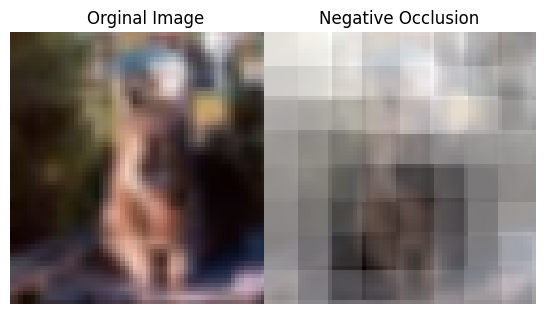

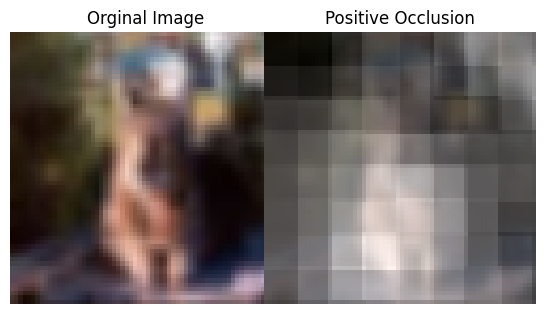

In [46]:
get_occlusion(custom_model,test_data_loader)

### Review outputs of Convolutional Layers

The image Class is: dog


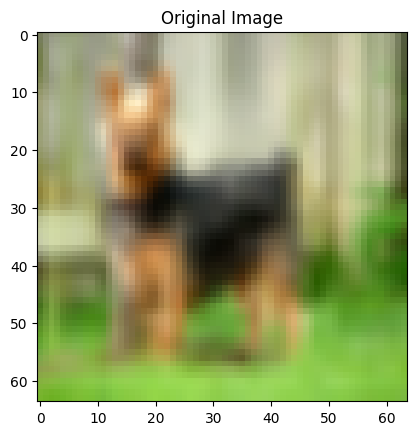

In [50]:
# Reset outputs#
layer_outputs = {}

# get output #
get_outputs(custom_model,test_data_loader)

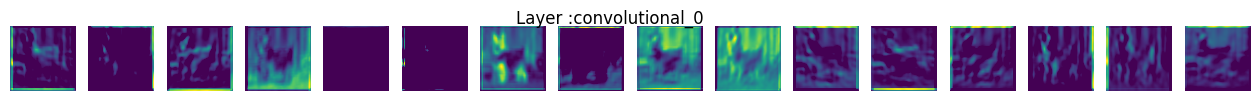

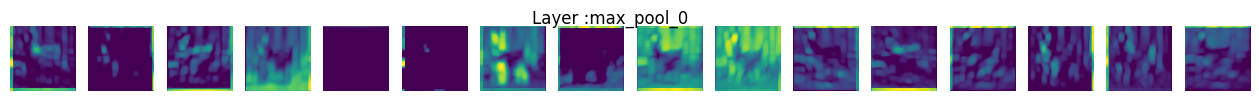

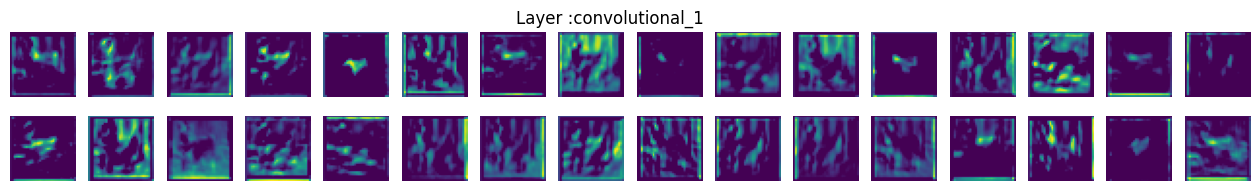

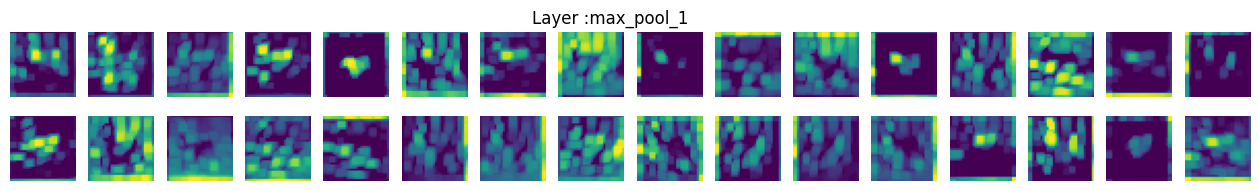

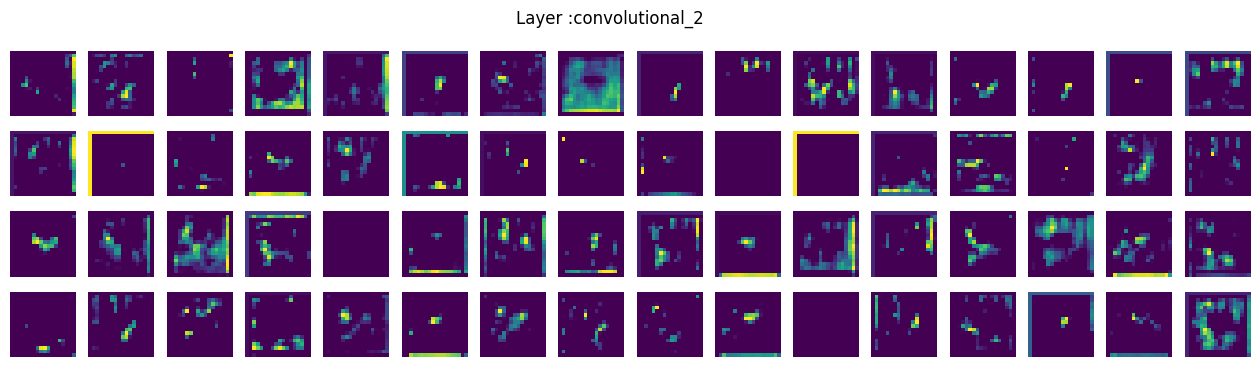

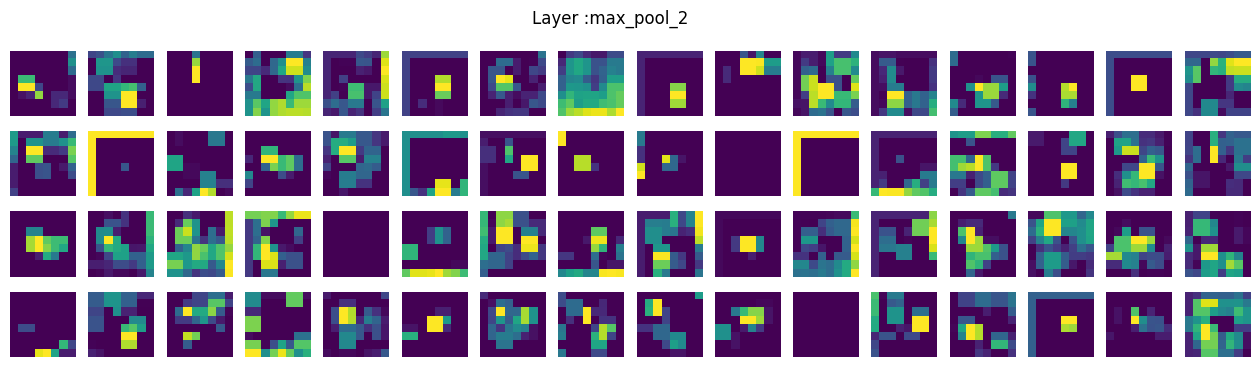

In [51]:
plot_model_outputs(layer_outputs)

### Hidden Layer explanaitions

- We can see the effect of the scale of the moddel on the max pooling 2 of the network, it also explains why the model can't train over certain accuracy.
- In the previous layers we can see the effect of the image, specially on the convolutional layer 0 and maxpooling layer 0, places where the kernels that are trained with certain patterns can detect patterns in the image.

### Final Explanaition

The AlexNet model used for the first test is an overfitted model for this task, even with the different transformations in the dataset, and tinkering with the hyperparameters of the network the accuracy stopped at a maximum of 73%. The model in the first layer captured the different characteristics of the network but getting deeper inside the convolutional layers we can see the patterns start to fade and the network is not trained througly. Also this network had an extensive train time because of the number of parameters so, its an expensive model to train in a personal computer.

The hybrid custom Net combines characteristics of the simpleness of LeeNet with the dropout and Maxpooling of Alexnet, this model trained better than Alexnet with the tinkered hyperparameters and have more potential to grow the test accuracy of 73.56% with more tinkering. This network is less expensive than AlexNet to train, but still requires a large amount of time to do it.
